In [5]:
import sys
import itertools
from repoze.lru import lru_cache

# Check the system type
if sys.platform == 'darwin':
    sys.path.append('/users/fluongo/documents/Python_stuff/subnets-ecog')
elif sys.platform == 'linux2':
    sys.path.append('/home/fluongo/python_modules/subnets-ecog')
    compSpec = '/Sohal'
else:
    sys.path.append('C:\\python_modules\\subnets-ecog')

import numpy as np
import matplotlib.pyplot as plt
import ecogRecordingParams as recParams
import ecogMiscellaneous as ecogMisc
import ecogVisualizations as ecogVis
import os
import networkx as nx
import datetime


import seaborn as sns
from pandas import DataFrame
import scipy.stats as stats
import ecogAnalysis

sns.set_style("white")
sns.set_style("ticks")

In [27]:
%matplotlib inline


def compute_projections(PC, coh_data):
    ''' Compute the projection given the 
    
    PCs in the form of nR x nR x nPCs
    coh_data in the form of nR x nR x nT
    
    '''
    
    # Compute the projections
    nR = coh_data.shape[0]; nT = coh_data.shape[2]
    projections = np.zeros([PC.shape[2], coh_data.shape[2]])
    for PCrank in range(PC.shape[2]):
        projections[PCrank, :] = np.dot(PC[:,:,PCrank].ravel(), coh_data.reshape([nR**2, nT]))
    
    return projections

def compute_R_v_loading(PC, coh_data):
    
    projections  = compute_projections(PC, coh_data)
    nR = coh_data.shape[0]; nT = coh_data.shape[2]
    # Generate the R value ditribution of each coherence to each projection
    
    PCloadingSums = []
    # Figure out the sum of loadings for each PC
    for PCrank in range(projections.shape[0]):
        temp_sum = []
        for i in range(nR):
            for j in range(i,nR):
                temp_sum.append(PC[i,j,PCrank])
        PCloadingSums.append(np.sum(np.abs(temp_sum)))
    
    print PCloadingSums
    
    # Go through and calculate the R**2 values/loading percentages

    for PCrank in range(projections.shape[0]):
        Rs = []; Ls = []
        for i in range(nR):
            for j in range(i,nR):
                Rs.append(ecogMisc.rsquared(coh_data[i,j,:], projections[PCrank]))
                Ls.append(np.abs(PC[i,j,PCrank]/PCloadingSums[PCrank]))
        plt.plot(Rs, Ls, '.',label = str(PCrank))
    plt.plot([0,1],[0,1],'k--')
    plt.legend(); plt.xlabel('R**2 value'); plt.ylabel('% loading')
    plt.xlim([0,1]); plt.ylim([0,1])
    
def shuffle_coherences(coh_data, totalShuffle = False, nShuffleRepeats = 5):
    ''' Shuffles coherences by shifting each train in time by a random number T relative to each other
    
    Arguments:
    
    coh_data -- Coherence data
    
    Output:
    
    coh_shuffled -- Shuffled version of the coherences
    '''
    
    coh_data = np.nan_to_num(coh_data)
    
    nR = coh_data.shape[0] # Number of regions
    nT = coh_data.shape[2] # Number of timepoints
    coh_shuffled = np.zeros_like(coh_data)
    
    if totalShuffle == False:
        rand_shift = np.random.randint(0, nT, size = (nR**2 + nR)/2)

        nn = 0
        for i in range(nR):
            for j in range(i, nR):
                # First shuffle
                shuffled_coh = np.hstack([coh_data[i,j,rand_shift[nn]:], coh_data[i,j,:rand_shift[nn]]])
                nn+=1
                
                # Subsequent Shuffles
                for kk in np.random.randint(0,nT, size = nShuffleRepeats):
                    shuffled_coh = np.hstack([shuffled_coh[kk:], shuffled_coh[:kk]])
                
                coh_shuffled[i,j,:] = shuffled_coh
                coh_shuffled[j,i,:] = coh_shuffled[i,j,:]
    
    if totalShuffle == True:
        for i in range(nR):
            for j in range(i, nR):
                coh_shuffled[i,j,:] = coh_data[i,j,np.random.permutation(range(nT))]
                coh_shuffled[j,i,:] = coh_shuffled[i,j,:]
    
    return coh_shuffled
    

In [32]:
np.linspace(0,1,100)

array([ 0.        ,  0.01010101,  0.02020202,  0.03030303,  0.04040404,
        0.05050505,  0.06060606,  0.07070707,  0.08080808,  0.09090909,
        0.1010101 ,  0.11111111,  0.12121212,  0.13131313,  0.14141414,
        0.15151515,  0.16161616,  0.17171717,  0.18181818,  0.19191919,
        0.2020202 ,  0.21212121,  0.22222222,  0.23232323,  0.24242424,
        0.25252525,  0.26262626,  0.27272727,  0.28282828,  0.29292929,
        0.3030303 ,  0.31313131,  0.32323232,  0.33333333,  0.34343434,
        0.35353535,  0.36363636,  0.37373737,  0.38383838,  0.39393939,
        0.4040404 ,  0.41414141,  0.42424242,  0.43434343,  0.44444444,
        0.45454545,  0.46464646,  0.47474747,  0.48484848,  0.49494949,
        0.50505051,  0.51515152,  0.52525253,  0.53535354,  0.54545455,
        0.55555556,  0.56565657,  0.57575758,  0.58585859,  0.5959596 ,
        0.60606061,  0.61616162,  0.62626263,  0.63636364,  0.64646465,
        0.65656566,  0.66666667,  0.67676768,  0.68686869,  0.69

[1462.5109662282021, 217.58537877407255, 240.18877664908314, 147.96908793472741, 112.43713233143026]
[1458.1195935371461, 69.287473723365309, 72.956304765272264, 91.67553346823577, 51.116270553748855]


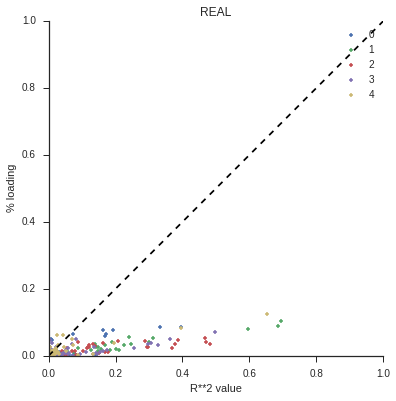

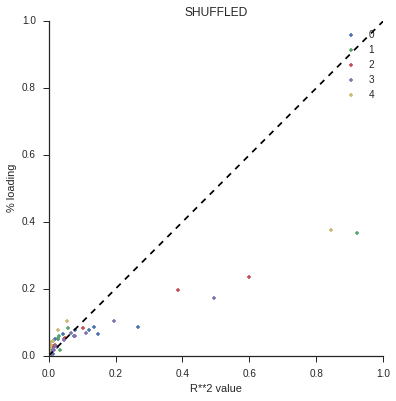

In [31]:
patientID = 'EC71'
band = 'alpha'

pc_data, coh_data, refNames = ecogMisc.load_data(patientID)
cohs = np.nan_to_num(coh_data[band])
PC, eigV = ecogAnalysis.pca_calculation(cohs, nPCs = 5)
plt.figure(figsize = [6,6])
compute_R_v_loading(PC, cohs); sns.despine(); plt.title('REAL')

cohs_shuff = shuffle_coherences(cohs, totalShuffle = False, nShuffleRepeats = 5)
PCshuff, eigV = ecogAnalysis.pca_calculation(cohs_shuff, nPCs = 5)
plt.figure(figsize = [6,6])
compute_R_v_loading(PCshuff, cohs_shuff); sns.despine(); plt.title('SHUFFLED')
